# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> IMT2118 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Semestre 2024-1**<br>
**Profesora:** Paula Aguirre <br>
**Ayudante:** Diego Pizarro <br>
**Integrantes:** Alu "Cachetes" Palu,Bastian Baez Oses
<br>





---

In [1]:
# Librerías generales para el análisis de datos geoespaciales
import pandas as pd
import geopandas as gpd
import geemap
import ee
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import folium
import os
import rasterio
import rasterio.mask
import seaborn as sns

# Librerías para el clustering
from sklearn.metrics import pairwise as skm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler


#librerías para regionalización
from libpysal import weights
#!pip install spopt
import spopt

In [2]:
# Ruta para guardar las figuras
save_cead_1 = os.path.join("imagenes-gif", "cead_1")
save_cead_2 = os.path.join("imagenes-gif", "cead_2")

In [3]:
#Inicializamos GEE
ee.Authenticate();
ee.Initialize(project='ee-bastianbaezos') #use su código de proyecto

In [4]:
# Funcion sacada de la ay. 4
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True, show=False).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [5]:
def getAOI(dat,crs=4326):
    aoi_coords = list(dat.geometry.unary_union.exterior.coords)
    aoi = ee.Geometry.Polygon(aoi_coords)
    return aoi

# La siguiente función fue sacada de:
# https://github.com/gee-community/geemap/issues/1095#issuecomment-1151812523
def fmask(image):
    # see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True).updateMask(qaMask)

def get_images(year_init, year_end, aoi):
    # Funcion creada usando de base la de la ayudantia 4
    years = list(range(year_init, year_end + 1))
    annual_imgs = {year: '' for year in years}

    for year in years:
        startDate = f'{year}-01-01'
        endDate = f'{year}-12-31'

        sentinelImageCollection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(aoi).filterDate(startDate, endDate)

        # Aplicamos fmask
        sentinelImageCollection = sentinelImageCollection.map(fmask)

        bandas = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']

        # Seleccionamos las bandas de interés
        sentinelImageCollection = sentinelImageCollection.select(bandas)

        # Geomedian ee.Reducer.geometricMedian()
        image = sentinelImageCollection.reduce(ee.Reducer.geometricMedian(numX=6)).clip(aoi)

        # Cambiar nombre de las bandas a "bandas"
        image = image.rename(bandas)

        # Agregar imagen al diccionario
        annual_imgs[year] = image

    return annual_imgs

In [6]:
# Include the following indices - Normalized difference built-up index (NDBI), 
# Normalized Difference Thermal Index (NDTI) and Buildup Index (BUI)

#Codigo obtenido de https://github.com/amasud08/Project_MRes/blob/main/notebooks/3_image_statistics.ipynb
#modificado para su uso en esta parte
def indices(img):
    
    #bandas = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
    img = img.select(
        ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"])
    
    # calculate ndvi
    ndvi = img.normalizedDifference(["NIR", "Red"]).rename('NDVI')

    img = img.addBands(ndvi)
    
    # calculate ndbi
    ndbi = img.normalizedDifference(["SWIR1", "NIR"]).rename('NDBI')
    
    # calculate mndbi
    mndbi = img.normalizedDifference(["SWIR2", "Blue"]).rename('MNDBI')
    
    
    buiA = img.expression("(SWIR1 - NIR) / (SWIR1 + NIR)", {
        "SWIR1": img.select("SWIR1"),
        "NIR": img.select("NIR")
    }).rename("BUI_A")
    
    buiB = img.expression("(NIR - Red) / (NIR + Red)", {
        "NIR": img.select("NIR"),
        "Red": img.select("Red")
    }).rename("BUI_B")
        
    bui_AB = buiA.addBands(buiB);
    bui = bui_AB.normalizedDifference(["BUI_A", "BUI_B"]).rename("BUI")
    
    #Calculate Index-Based Built-Up Index (IBI)
    # https://bikeshbade.com.np/tutorials/Detail/?title=Most%20used%20spectral%20Indices%20with%20free%20satellite%20data&code=23
    ibiA = img.expression('2 * SWIR1 / (SWIR1 + NIR)', {
        'SWIR1': img.select('SWIR1'),
        'NIR'  : img.select('NIR')}).rename("IBI_A")
    
    ibiB = img.expression('(NIR / (NIR + Red)) + (Green / (Green + SWIR1))', {
        "NIR"  : img.select("NIR"),
        "Red"  : img.select("Red"),
        "Green": img.select("Green"),
        "SWIR1": img.select("SWIR1")}).rename("IBI_B")
    
    ibiAB = ibiA.addBands(ibiB);
    ibi = ibiAB.normalizedDifference(["IBI_A", "IBI_B"]).rename("IBI")
    
    img.addBands(ibi)
    
    # Calculate ENDISI - https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Urban_change_detection.html
    swir_diff = img.expression("SWIR1 / SWIR2", {"SWIR1": img.select("SWIR1"), "SWIR2": img.select("SWIR2"),
                                                }).rename('swir_diff')
    
     
    mndwi = img.normalizedDifference(["Green", "SWIR1"]).rename('MNDWI')
 
    img = img.addBands([swir_diff, mndwi])
    
    blue_mean = img.select("Blue").reduceRegion(ee.Reducer.mean(), aoi).toImage().rename("blue_mean")
    
    swir_mean = img.select("swir_diff").reduceRegion(ee.Reducer.mean(), aoi).toImage().rename("swir_mean")
    
    mndwi_mean = img.select("MNDWI").multiply(img.select("MNDWI")).reduceRegion(ee.Reducer.mean(), aoi).toImage().rename("mndwi_mean")
    
    img = img.addBands([blue_mean, swir_mean, mndwi_mean])
    
    alpha = img.expression('(2 * b("blue_mean")) / (b("swir_mean") +  b("mndwi_mean"))').rename("alpha")
    
    img = img.addBands(alpha)
    
    ENDISI = img.expression('(b("Blue") - b("alpha") * (b("swir_diff") + b("MNDWI")**2)) / (b("Blue") + b("alpha") * (b("swir_diff") + b("MNDWI")**2))').rename("ENDISI")

    img = img.addBands(ENDISI)
    
    return  img

# Comunas

In [7]:
# Nuestro crs
n_crs = 4326

In [8]:
# obtener poligonos de comunas
comunas=gpd.read_file('Datos\R13\COMUNA_C17.shp')
display(comunas.head(5))
comunas = comunas.to_crs(epsg=n_crs)

# Crs de las comunas
print(comunas.crs)

# imprimir nombre de las comunas, para seleccionar la que queremos
print(comunas['NOM_COMUNA'].unique())

REGION                        NOM_REGION PROVINCIA NOM_PROVIN COMUNA  \
0     13  REGIÓN METROPOLITANA DE SANTIAGO       134      MAIPO  13404   
1     13  REGIÓN METROPOLITANA DE SANTIAGO       134      MAIPO  13402   
2     13  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  13124   
3     13  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  13103   
4     13  REGIÓN METROPOLITANA DE SANTIAGO       133  CHACABUCO  13301   

    NOM_COMUNA  SHAPE_Leng  SHAPE_Area  \
0        PAINE    1.625330    0.066035   
1         BUIN    0.884164    0.021166   
2     PUDAHUEL    0.720176    0.019124   
3  CERRO NAVIA    0.170180    0.001076   
4       COLINA    1.692007    0.093820   

                                            geometry  
0  POLYGON ((-70.61889 -33.73808, -70.61811 -33.7...  
1  POLYGON ((-70.63192 -33.64634, -70.63207 -33.6...  
2  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...  
3  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...  
4  POLYGON ((-70.59630 -32.95138, -70.59673 -32.9...

EPSG:4326
['PAINE' 'BUIN' 'PUDAHUEL' 'CERRO NAVIA' 'COLINA' 'TILTIL' 'LAMPA'
 'HUECHURABA' 'CONCHALÍ' 'MARÍA PINTO' 'CURACAVÍ' 'LA PINTANA' 'EL BOSQUE'
 'ESTACIÓN CENTRAL' 'PEDRO AGUIRRE CERDA' 'RECOLETA' 'INDEPENDENCIA'
 'ISLA DE MAIPO' 'LO ESPEJO' 'LA CISTERNA' 'LA FLORIDA' 'PEÑALOLÉN'
 'LAS CONDES' 'LA REINA' 'LO BARNECHEA' 'VITACURA' 'QUINTA NORMAL'
 'LO PRADO' 'CERRILLOS' 'MAIPÚ' 'MELIPILLA' 'MACUL' 'ÑUÑOA' 'PEÑAFLOR'
 'PADRE HURTADO' 'PUENTE ALTO' 'QUILICURA' 'RENCA' 'CALERA DE TANGO'
 'SAN BERNARDO' 'SAN JOSÉ DE MAIPO' 'PIRQUE' 'SAN JOAQUÍN' 'SAN MIGUEL'
 'SAN RAMÓN' 'LA GRANJA' 'PROVIDENCIA' 'SANTIAGO' 'EL MONTE' 'TALAGANTE'
 'SAN PEDRO' 'ALHUÉ']


In [9]:
# Escogemos las comunas que queremos
m_comunas = "CERRILLOS,CERRO NAVIA,CONCHALÍ,EL BOSQUE,ESTACIÓN CENTRAL,HUECHURABA,INDEPENDENCIA,LA CISTERNA,LA FLORIDA,LA GRANJA,LA PINTANA,LA REINA,LAS CONDES,LO ESPEJO,LO PRADO,MACUL,MAIPÚ,ÑUÑOA,PEDRO AGUIRRE CERDA,PEÑALOLÉN,PROVIDENCIA,PUDAHUEL,PUENTE ALTO,QUILICURA,QUINTA NORMAL,RECOLETA,RENCA,SAN BERNARDO,SAN JOAQUÍN,SAN MIGUEL,SAN RAMÓN,SANTIAGO,VITACURA,MÁCUL".split(',')
print(m_comunas)
print(len(m_comunas))

# Filtrar comunas
comunas = comunas[comunas.NOM_COMUNA.isin(m_comunas)]
# Resetear index
comunas.reset_index(drop=True, inplace=True)

# Columnas de interes
comunas = comunas[['NOM_COMUNA', 'geometry']]

# Visualizar comunas
display(comunas.head(5))

['CERRILLOS', 'CERRO NAVIA', 'CONCHALÍ', 'EL BOSQUE', 'ESTACIÓN CENTRAL', 'HUECHURABA', 'INDEPENDENCIA', 'LA CISTERNA', 'LA FLORIDA', 'LA GRANJA', 'LA PINTANA', 'LA REINA', 'LAS CONDES', 'LO ESPEJO', 'LO PRADO', 'MACUL', 'MAIPÚ', 'ÑUÑOA', 'PEDRO AGUIRRE CERDA', 'PEÑALOLÉN', 'PROVIDENCIA', 'PUDAHUEL', 'PUENTE ALTO', 'QUILICURA', 'QUINTA NORMAL', 'RECOLETA', 'RENCA', 'SAN BERNARDO', 'SAN JOAQUÍN', 'SAN MIGUEL', 'SAN RAMÓN', 'SANTIAGO', 'VITACURA', 'MÁCUL']
34


NOM_COMUNA                                           geometry
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...

In [10]:
# Agregar "LO BARNECHEA"

m_comunas.append("LO BARNECHEA")

from obtener_barnechea import barnechea
barnechea()

# leer "LO BARNECHEA"
lo_barnechea = gpd.read_file('Datos\LO_BARNECHEA\lo_barnechea.gpkg')
lo_barnechea = lo_barnechea.to_crs(epsg=n_crs)

# Agregar "LO BARNECHEA" a comunas
comunas = comunas.append(lo_barnechea)

# Resetear index
comunas.reset_index(drop=True, inplace=True)

# Visualizar comunas
display(comunas.head(5))


Obteniendo la comuna de Lo Barnechea...


C:\Users\itsab\AppData\Local\Temp\ipykernel_5040\1178342960.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comunas = comunas.append(lo_barnechea)


NOM_COMUNA                                           geometry
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...

In [11]:
aoi = getAOI(comunas)
aoi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -70.63216210499996,
              -33.64518685599995
            ],
            [
              -70.63238355099998,
              -33.64516477199993
            ],
            [
              -70.63277298299994,
              -33.645125933999964
            ],
            [
              -70.63346541499993,
              -33.64501785199997
            ],
            [
              -70.63362174499997,
              -33.64502476699994
            ],
            [
              -70.63386627099999,
              -33.645035581999934
            ],
            [
              -70.63444412799998,
              -33.64506114099993
            ],
            [
              -70.63544297899995,
              -33.64522284099996
            ],
            [
              -70.63646944199996,
              -33.645414725999956
            ],
            [
              -70.63647634299997,
              -33.645416015999956
            ],
            [
              -70.63670103599998,
              -33.64545696199997
            ],
            [
              -70.63734384599996,
              -33.645574102999944
            ],
            [
              -70.63762243499997,
              -33.64567071799996
            ],
            [
              -70.63835808699997,
              -33.645925844999965
            ],
            [
              -70.63900021899997,
              -33.64614853699993
            ],
            [
              -70.63919516899995,
              -33.64618787999996
            ],
            [
              -70.64015842299995,
              -33.646382277999976
            ],
            [
              -70.64224436399996,
              -33.64659764299995
            ],
            [
              -70.64232312999997,
              -33.646605774999955
            ],
            [
              -70.64265627899994,
              -33.64658580599996
            ],
            [
              -70.64332935699997,
              -33.64654546099996
            ],
            [
              -70.64408965199993,
              -33.646610083999974
            ],
            [
              -70.64412202999995,
              -33.64661894999995
            ],
            [
              -70.64418822599998,
              -33.646637075999934
            ],
            [
              -70.64438322699993,
              -33.64669047299998
            ],
            [
              -70.64459403399997,
              -33.646748197999955
            ],
            [
              -70.64479164999995,
              -33.64680231099993
            ],
            [
              -70.64480356299998,
              -33.64680429899994
            ],
            [
              -70.64522866399994,
              -33.64687523699996
            ],
            [
              -70.64523944499996,
              -33.64687703599998
            ],
            [
              -70.64527986199994,
              -33.646940564999966
            ],
            [
              -70.64532023999993,
              -33.64700207899995
            ],
            [
              -70.64557570299996,
              -33.647034832999964
            ],
            [
              -70.64601787699996,
              -33.64709152599994
            ],
            [
              -70.64617870199999,
              -33.647148984999944
            ],
            [
              -70.64637806999997,
              -33.64722021399996
            ],
            [
              -70.64677449099997,
              -33.64736184399993
            ],
            [
              -70.64693304799994,
              -33.64741849199993
            ],
            [
              -70.64696134899998,
              -33.647425331999955
            ],
            [
              -70.64716381799997,
              -

In [12]:
start_year = 2015
end_year = 2023

x,y =aoi.centroid().getInfo()["coordinates"]
dates=[start_year,end_year]
imagenes=get_images(start_year,end_year,aoi)
imagenes


{2015: <ee.image.Image at 0x22e1b32f210>,
 2016: <ee.image.Image at 0x22e1b30bc50>,
 2017: <ee.image.Image at 0x22e1b3091d0>,
 2018: <ee.image.Image at 0x22e1b2ec890>,
 2019: <ee.image.Image at 0x22e1b2edc50>,
 2020: <ee.image.Image at 0x22e214b9590>,
 2021: <ee.image.Image at 0x22e214b8d50>,
 2022: <ee.image.Image at 0x22e1b30a390>,
 2023: <ee.image.Image at 0x22e19675ed0>}

In [13]:
# Visualización de las imágenes
visualization_rgb = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0.0,
    'max': 0.3,
}
fmap = folium.Map(location=[y,x], zoom_start=10)

for year in imagenes.keys():
    image = imagenes[year]
    fmap.add_ee_layer(image, visualization_rgb, name=str(year))

fmap.add_child(folium.LayerControl())
display(fmap)

# Pixeles muertos. Puede ser por valores de reflectancia fuera de rango.

In [14]:
## TIMELAPSE GIF RGB

# Codigo inspirado en ayudantia 4
video_args_rgb = {
    'dimensions': (1200,600),
    'region': aoi,
    'framesPerSecond': 1,
    'crs': 'EPSG:4326',
    'min': 0.0,
    'max': 0.3,
    'bands': ['SR_B3', 'SR_B2', 'SR_B1']
}

# Convertir el diccionario de imagenes a una coleccion de imagenes
timelapse_imagenes = list(imagenes.values())
timelapse_imagenes = ee.ImageCollection.fromImages(timelapse_imagenes)

# Crear el gif
gif_url = timelapse_imagenes.getVideoThumbURL(video_args_rgb)
gif_url

# Codigo inspirado de https://book.geemap.org/chapters/09_timelapse.html

in_gif = r'imagenes-gif\timelapse.gif'
on_gif = r'imagenes-gif\timelapse_with_text.gif'
geemap.download_file(gif_url, in_gif, overwrite=True)
geemap.add_text_to_gif(
    in_gif,
    on_gif,
    xy=('3%', '5%'),
    text_sequence=start_year,
    font_size=30,
    font_color='#ffffff',
    add_progress_bar=True,
    progress_bar_color='#ffffff',
    progress_bar_height=5,
    duration=1000,
    loop=0,
)

geemap.show_image(on_gif)

geemap.download_file

Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-bastianbaezos/videoThumbnails/ca3ba6938ab1d500e4e960550647c6dc-d295a0ec03ecc4a9528f71d0d89628c2:getPixels
To: c:\Users\itsab\OneDrive\Escritorio\Universidad\2024-1\IMT2118 - Geo\Proyecto-Geoespaciales\imagenes-gif\timelapse.gif
100%|██████████| 1.74M/1.74M [00:00<00:00, 1.85MB/s]


Output()

<function geemap.common.download_file(url=None, output=None, quiet=False, proxy=None, speed=None, use_cookies=True, verify=True, id=None, fuzzy=False, resume=False, unzip=True, overwrite=False)>

In [15]:
imagenes = {year: indices(img) for year, img in imagenes.items()}

# imprimir las bandas de la imagen
imagenes[start_year].bandNames().getInfo()

['Blue',
 'Green',
 'Red',
 'NIR',
 'SWIR1',
 'SWIR2',
 'NDVI',
 'swir_diff',
 'MNDWI',
 'blue_mean',
 'swir_mean',
 'mndwi_mean',
 'alpha',
 'ENDISI']

In [16]:
## CMAPS

# Lista de paleta de colores
smooth_colors = ['#005bb0', '#70a2e7', '#f5f5f5', '#ff7f50', '#ff1c22'] 

# Palette de colores
smooth_cmap = mcolors.LinearSegmentedColormap.from_list('smooth_cmap', ['#005bb0', '#70a2e7', '#f5f5f5', '#ff7f50', '#ff1c22'])


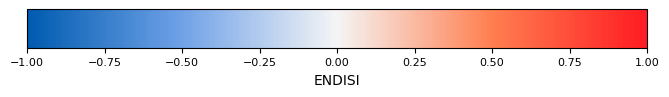

In [17]:
## COLORBAR ENDISI

vmin = -1
vmax = 1

# Crear una figura de matplotlib para el colorbar
fig, ax = plt.subplots(figsize=(8, 0.5))
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=smooth_cmap), 
                  cax=ax, orientation='horizontal')
cb.set_label('ENDISI', fontsize=10)
cb.ax.tick_params(labelsize=8)

# Guardar el colorbar como una imagen
colorbar_file_endisi = 'imagenes-gif/colorbar-endisi.png'
plt.savefig(colorbar_file_endisi, bbox_inches='tight', dpi=300)

In [18]:
## TIMELAPSE GIF ENDISI

# Convertir el diccionario de imagenes a una coleccion de imagenes
timelapse_imagenes = list(imagenes.values())
timelapse_imagenes = ee.ImageCollection.fromImages(timelapse_imagenes)

# Crea el gif con las zonas y las imágenes de ENDISI
video_args = {
    'dimensions': (1200,600),
    'region': aoi,
    'framesPerSecond': 1,
    'crs': 'EPSG:4326',
    'min': vmin,
    'max': vmax,
    'bands': ['ENDISI'],
    'palette': smooth_colors
}

gif_url = timelapse_imagenes.getVideoThumbURL(video_args)

in_gif = r'imagenes-gif\timelapse_ENDISI.gif'
geemap.download_file(gif_url, in_gif, overwrite=True)
geemap.show_image(in_gif)


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-bastianbaezos/videoThumbnails/1345c91da519b1a514bdef3f5f54d0ba-dca4553b8110733d59b3d2c83ff6d1ba:getPixels
To: c:\Users\itsab\OneDrive\Escritorio\Universidad\2024-1\IMT2118 - Geo\Proyecto-Geoespaciales\imagenes-gif\timelapse_ENDISI.gif
100%|██████████| 1.84M/1.84M [00:01<00:00, 1.73MB/s]


Output()

In [19]:
# Agregar años al gif
on_gif = r'imagenes-gif\timelapse_ENDISI_text.gif'
geemap.add_text_to_gif(
    in_gif,
    on_gif,
    xy=('3%', '5%'),
    text_sequence=start_year,
    font_size=30,
    font_color='white',
    add_progress_bar=True,
    progress_bar_color='#ffffff',
    progress_bar_height=5,
    duration=1000,
    loop=0,
)
geemap.add_image_to_gif(in_gif=on_gif, out_gif=on_gif, in_image=colorbar_file_endisi, xy = ('55%', '80%'), image_size=(1200, 80))
geemap.show_image(on_gif)

Output()

In [20]:
out_dir = os.path.join(os.getcwd(), 'imagenes-gif', 'rasters')

# Descargar rasters
# Código comentado para evitar descargas innecesarias, ya que los rasters ya están descargados
# for year, img in imagenes.items():
#     print(f"Descargando {year}")
#     url = img.getDownloadURL({
#         'bands': ['ENDISI'],
#         'region': aoi,
#         'scale': 30,
#         'format': 'GeoTIFF'
#     })
#     out_file = os.path.join(out_dir, f'{year}.tif')
#     geemap.download_file(url, out_file, overwrite=True)
    

In [21]:
# Leer los archivos tif
rasters = [os.path.join(out_dir, f) for f in os.listdir(out_dir) if f.endswith('.tif')]
rasters.sort()

for r in rasters:
    with rasterio.open(r) as src:
        means_endisi = []

        for index, row in comunas.iterrows():
            geometry = [row['geometry']]
            out_image, out_transform = rasterio.mask.mask(src, geometry, crop=True)
            out_image = out_image[0]  # Sólo una banda
            # Máscara de valores no válidos
            out_image = np.ma.masked_equal(out_image, src.nodata)
            # Calcular el promedio excluyendo valores nodata
            mean_endisi = out_image.mean()
            means_endisi.append(mean_endisi)
        comunas[f'mean_endisi_{os.path.basename(r).split(".")[0]}'] = means_endisi
        print(f'Termine el año {os.path.basename(r).split(".")[0]}')
        

Termine el año 2015
Termine el año 2016
Termine el año 2017
Termine el año 2018
Termine el año 2019
Termine el año 2020
Termine el año 2021
Termine el año 2022
Termine el año 2023


In [22]:
# Cargar los datos de criminalidad y calidad de vida urbana
ruta_cead_1 = r"Datos\CEAD\reportes-unidadTerritorial.xlsx"
cead_1 = pd.read_excel(ruta_cead_1, thousands='.', decimal=',')

# Convertir la columna "Unidad Territorial" a mayúsculas
cead_1['UNIDAD TERRITORIAL'] = cead_1['UNIDAD TERRITORIAL'].str.upper()

display(cead_1.head(5))

UNIDAD TERRITORIAL      2015      2016      2017      2018      2019  \
0               TOTAL PAÍS  889198.0  844796.0  850619.0  845158.0  873749.0   
1     REGIÓN METROPOLITANA  383483.0  357755.0  364268.0  367773.0  382671.0   
2    PROVINCIA DE SANTIAGO  297331.0  276814.0  280191.0  280241.0  291141.0   
3                 SANTIAGO   39847.0   37161.0   39595.0   38783.0   39912.0   
4                CERRILLOS    5686.0    5145.0    4932.0    5374.0    5783.0   

       2020      2021      2022      2023  
0  675008.0  666422.0  854545.0  885513.0  
1  279458.0  271680.0  342295.0  354671.0  
2  209809.0  202228.0  259963.0  271951.0  
3   24571.0   25212.0   36113.0   38491.0  
4    4132.0    3785.0    5125.0    5304.0

In [23]:
# Eliminar las filas que en la columna "Unidad Territorial" no estén en la lista de comunas
cead_1['UNIDAD TERRITORIAL'] = cead_1['UNIDAD TERRITORIAL'].map(str.strip)
cead_1 = cead_1[cead_1["UNIDAD TERRITORIAL"].isin(m_comunas)]
cead_1 = cead_1.reset_index(drop=True)
display(cead_1.head(5))

UNIDAD TERRITORIAL     2015     2016     2017     2018     2019     2020  \
0           SANTIAGO  39847.0  37161.0  39595.0  38783.0  39912.0  24571.0   
1          CERRILLOS   5686.0   5145.0   4932.0   5374.0   5783.0   4132.0   
2        CERRO NAVIA   4582.0   4601.0   4431.0   4892.0   5105.0   4432.0   
3           CONCHALÍ   5256.0   5141.0   5501.0   5962.0   6669.0   5308.0   
4          EL BOSQUE   7913.0   6971.0   7692.0   7732.0   7777.0   5658.0   

      2021     2022     2023  
0  25212.0  36113.0  38491.0  
1   3785.0   5125.0   5304.0  
2   4598.0   5467.0   6610.0  
3   4578.0   5404.0   5942.0  
4   5501.0   6130.0   6539.0

In [24]:
# Join de las cead_1 con las comunas
cead_comunas_1 = comunas.merge(cead_1, left_on='NOM_COMUNA', right_on='UNIDAD TERRITORIAL', how='inner')
cead_comunas_1 = cead_comunas_1.drop(columns=['UNIDAD TERRITORIAL'])
display(cead_comunas_1.head(5))

NOM_COMUNA                                           geometry  \
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...   
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...   
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...   
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...   
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...   

   mean_endisi_2015  mean_endisi_2016  mean_endisi_2017  mean_endisi_2018  \
0         -0.098868         -0.081216         -0.074662         -0.067701   
1          0.224280          0.242552          0.261091          0.219806   
2         -0.111830         -0.057266         -0.094771         -0.120563   
3          0.231258          0.260440          0.282941          0.249246   
4          0.072726          0.085928          0.117267          0.094583   

   mean_endisi_2019  mean_endisi_2020  mean_endisi_2021  mean_endisi_2022  \
0         -0.079220         -0.040010         -0.059132         -0.058857   
1          0.198873          0.208580          0.193865          0.206738   
2         -0.144225         -0.124776         -0.167283         -0.126357   
3          0.218385          0.218902          0.196848          0.194019   
4          0.058612          0.054557          0.000846          0.037702   

   mean_endisi_2023     2015    2016    2017     2018     2019    2020  \
0         -0.014481  10406.0  9410.0  9534.0  10931.0  11669.0  8816.0   
1          0.258278   4582.0  4601.0  4431.0   4892.0   5105.0  4432.0   
2         -0.094749   6291.0  5521.0  5395.0   5196.0   5413.0  3773.0   
3          0.237533   5256.0  5141.0  5501.0   5962.0   6669.0  5308.0   
4          0.094690   8809.0  8197.0  7945.0   8216.0   8608.0  6618.0   

     2021     2022     2023  
0  8874.0  10716.0  11999.0  
1  4598.0   5467.0   6610.0  
2  3706.0   4371.0   4701.0  
3  4578.0   5404.0   5942.0  
4  6114.0   7271.0   7498.0

In [25]:
# Calcular la densidad de criminalidad por km²
for year in range(start_year, end_year + 1):
    cead_comunas_1[year] = cead_comunas_1[year] / (cead_comunas_1['geometry'].to_crs(epsg=32719).area / 10**6)
display(cead_comunas_1.head(5))

NOM_COMUNA                                           geometry  \
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...   
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...   
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...   
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...   
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...   

   mean_endisi_2015  mean_endisi_2016  mean_endisi_2017  mean_endisi_2018  \
0         -0.098868         -0.081216         -0.074662         -0.067701   
1          0.224280          0.242552          0.261091          0.219806   
2         -0.111830         -0.057266         -0.094771         -0.120563   
3          0.231258          0.260440          0.282941          0.249246   
4          0.072726          0.085928          0.117267          0.094583   

   mean_endisi_2019  mean_endisi_2020  mean_endisi_2021  mean_endisi_2022  \
0         -0.079220         -0.040010         -0.059132         -0.058857   
1          0.198873          0.208580          0.193865          0.206738   
2         -0.144225         -0.124776         -0.167283         -0.126357   
3          0.218385          0.218902          0.196848          0.194019   
4          0.058612          0.054557          0.000846          0.037702   

   mean_endisi_2023        2015        2016        2017        2018  \
0         -0.014481   52.753159   47.703943   48.332560   55.414644   
1          0.258278  412.891030  414.603149  399.284189  440.825605   
2         -0.094749  140.116659  122.966790  120.160447  115.728208   
3          0.237533  473.097396  462.746140  495.150072  536.645106   
4          0.094690  289.281193  269.183555  260.908057  269.807501   

         2019        2020        2021        2022        2023  
0   59.155930   44.692663   44.986693   54.324702   60.828864  
1  460.019361  399.374301  414.332815  492.639734  595.637213  
2  120.561353   84.034359   82.542098   97.353349  104.703292  
3  600.282826  477.777964  412.069992  486.419012  534.844887  
4  282.680498  217.330336  200.779341  238.774384  246.228900

In [26]:
# Promedio de criminalidad de los años 2015 a 2023
cead_comunas_1['mean_cead'] = cead_comunas_1[[year for year in range(start_year, end_year + 1)]].mean(axis=1)

# Promedio endisi de los años 2015 a 2023
cead_comunas_1['mean_endisi'] = cead_comunas_1[[f'mean_endisi_{year}' for year in range(start_year, end_year + 1)]].mean(axis=1)

# Seleccionar columnas de interés
cead_comunas_1 = cead_comunas_1[['NOM_COMUNA', 'mean_cead', 'mean_endisi', 'geometry']]
display(cead_comunas_1.head(5))

NOM_COMUNA   mean_cead  mean_endisi  \
0     PUDAHUEL   52.021462    -0.063794   
1  CERRO NAVIA  447.734155     0.223785   
2   HUECHURABA  109.796284    -0.115758   
3     CONCHALÍ  497.670377     0.232175   
4   LA PINTANA  252.774863     0.068546   

                                            geometry  
0  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...  
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...  
2  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...  
3  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...  
4  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...

In [27]:
# Cargar datos de calidad de vida urbana (ICVU)
gdf_icvu = gpd.read_file("Datos\CALIDAD\ICVU_2017.geojson")
columnas_icvu = ['nom_com', 'icvu_2017']
gdf_icvu = gdf_icvu[columnas_icvu]
gdf_icvu = gdf_icvu.rename(columns={'nom_com': 'NOM_COMUNA'})
gdf_icvu['NOM_COMUNA'] = gdf_icvu['NOM_COMUNA'].str.upper()
gdf_icvu = gdf_icvu[gdf_icvu['NOM_COMUNA'].isin(m_comunas)]
gdf_icvu = gdf_icvu.reset_index(drop=True)

# Corregir nombre de comuna
gdf_icvu.loc[gdf_icvu['NOM_COMUNA'] == 'MÁCUL', 'NOM_COMUNA'] = 'MACUL'
display(gdf_icvu.head(5))

NOM_COMUNA  icvu_2017
0         CERRILLOS       32.6
1       CERRO NAVIA       26.9
2          CONCHALÍ       30.7
3         EL BOSQUE       28.0
4  ESTACIÓN CENTRAL       33.4

In [28]:
# Join de las comunas con el ICVU
cead_comunas_1 = cead_comunas_1.merge(gdf_icvu, on='NOM_COMUNA', how='inner')
display(cead_comunas_1.head(5))

NOM_COMUNA   mean_cead  mean_endisi  \
0     PUDAHUEL   52.021462    -0.063794   
1  CERRO NAVIA  447.734155     0.223785   
2   HUECHURABA  109.796284    -0.115758   
3     CONCHALÍ  497.670377     0.232175   
4   LA PINTANA  252.774863     0.068546   

                                            geometry  icvu_2017  
0  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...       36.2  
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...       26.9  
2  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...       37.2  
3  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...       30.7  
4  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...       24.2

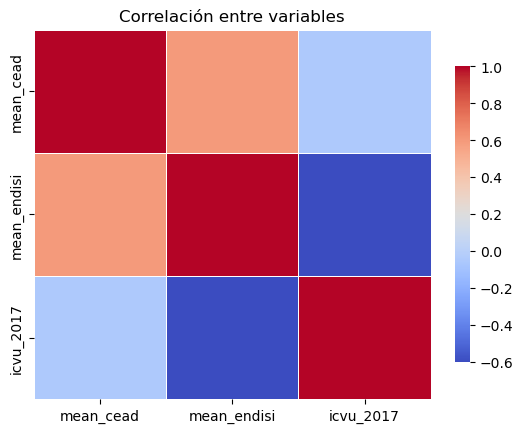

In [29]:
corr = cead_comunas_1.corr()
sns.heatmap(corr, square=False, linewidths=.5, cbar_kws={"shrink": .8},cmap='coolwarm');
plt.title('Correlación entre variables')

# Guardar la figura
guardar = os.path.join(save_cead_1, 'correlacion.png')
plt.savefig(guardar)

plt.show()


In [30]:
cl_var = ['mean_cead', 'mean_endisi', 'icvu_2017']
cl_var_norm = [f'{var}_norm' for var in cl_var]

# Normalizar las variables con StandardScaler
scaler = StandardScaler()
cead_comunas_1[cl_var_norm] = scaler.fit_transform(cead_comunas_1[cl_var])

cead_comunas_1.head(5)


NOM_COMUNA   mean_cead  mean_endisi  \
0     PUDAHUEL   52.021462    -0.063794   
1  CERRO NAVIA  447.734155     0.223785   
2   HUECHURABA  109.796284    -0.115758   
3     CONCHALÍ  497.670377     0.232175   
4   LA PINTANA  252.774863     0.068546   

                                            geometry  icvu_2017  \
0  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...       36.2   
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...       26.9   
2  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...       37.2   
3  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...       30.7   
4  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...       24.2   

   mean_cead_norm  mean_endisi_norm  icvu_2017_norm  
0       -1.254470         -1.130948       -0.269381  
1        0.060589          0.779308       -0.980981  
2       -1.062469         -1.476118       -0.192865  
3        0.226540          0.835039       -0.690220  
4       -0.587313         -0.251876       -1.187574

In [31]:
# Método de la silueta para determinar el número óptimo de clusters
def silhouette_method(data, ruta,max_clusters=10, geo={'type': 'ahc', 'w':None,'attrs_name': None}):
    silhouette_avg = []
    for k in range(2, max_clusters + 1):
        if geo['type'] == 'ahc_spatial':
            agg_clust = AgglomerativeClustering(n_clusters=k, connectivity=geo['w'].sparse)
            labels = agg_clust.fit_predict(data)
            silhouette_avg.append(metrics.silhouette_score(data, labels))
        elif geo['type'] == 'ahc':
            agg_clust = AgglomerativeClustering(n_clusters=k)
            labels = agg_clust.fit_predict(data)
            silhouette_avg.append(metrics.silhouette_score(data, labels))
        elif geo['type'] == 'skater':
            spanning_forest_kwds = geo['spanning_forest_kwds']
            model = spopt.region.Skater(data, geo['w'], geo['attrs_name'], n_clusters=k, floor=10, trace=False, islands="increase", spanning_forest_kwds=spanning_forest_kwds)
            model.solve()
            labels = model.labels_
            silhouette_avg.append(metrics.silhouette_score(data[geo['attrs_name']], labels))
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_avg, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Método de la silueta')
    # Guardar la figura
    guardar = os.path.join(ruta, f"silhouette_method_{geo['type']}.png")
    plt.savefig(guardar)
    plt.show()    
    return silhouette_avg

def elbow_method(data, ruta,max_clusters=10):
    sse = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), sse, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('SSE')
    plt.title('Método del codo')
    # Guardar la figura
    guardar = os.path.join(ruta, 'elbow_method_kmeans.png')
    plt.savefig(guardar)
    plt.show()
    return sse




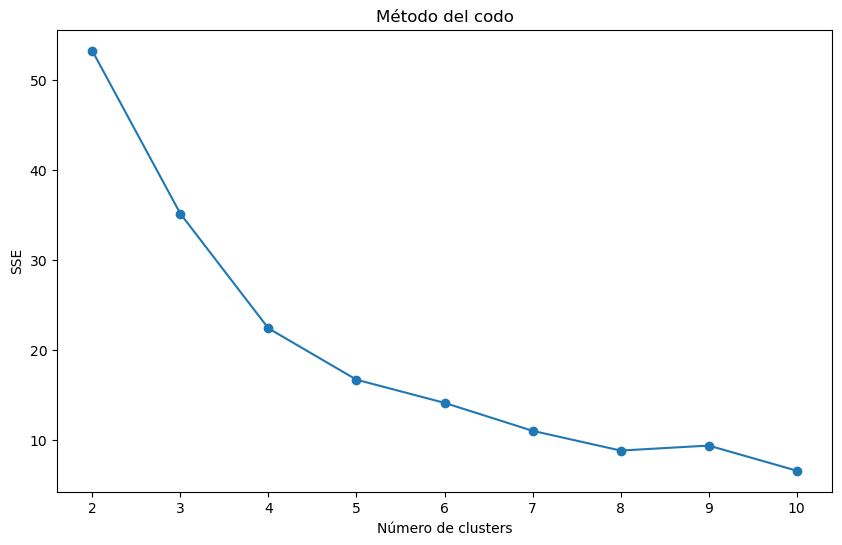

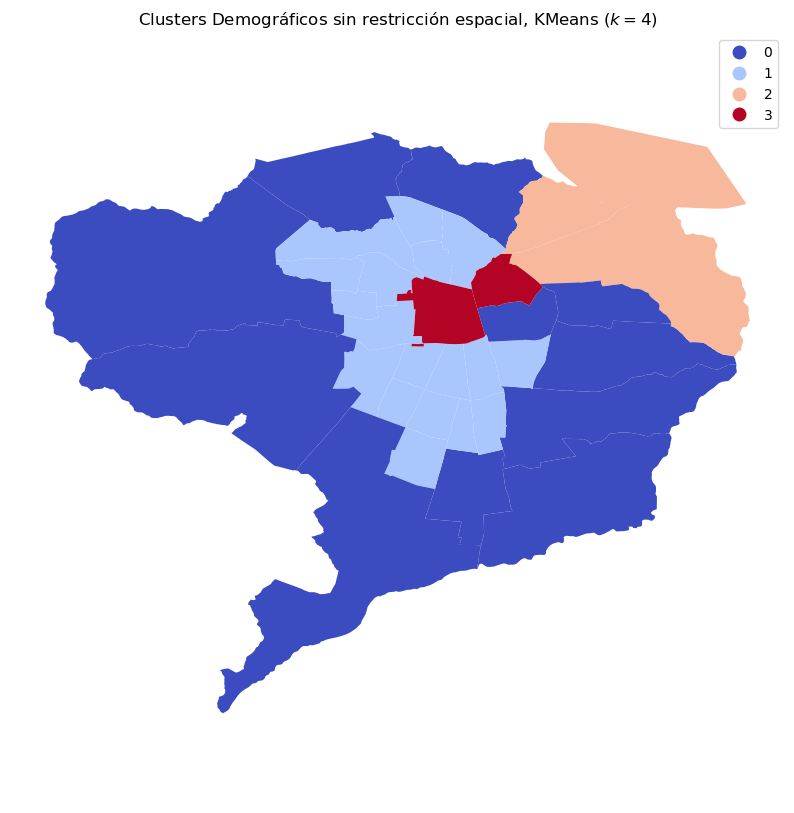

In [32]:
# Aplicar método del codo
elbow_method(cead_comunas_1[cl_var_norm], max_clusters=10, ruta=save_cead_1)

# Al ver el gráfico, se puede observar que el codo se encuentra en k=3, por lo que se utilizarán 4 clusters
n_clusters = 4

# Realizar KMeans
kmeans = KMeans(n_clusters=n_clusters)
cead_comunas_1['KMeans'] = kmeans.fit_predict(cead_comunas_1[cl_var_norm])

# Visualizar los clusters
f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_1.plot(column='KMeans', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos sin restricción espacial, KMeans ($k=%d$)'%n_clusters)

# Guardar la figura
guardar = os.path.join(save_cead_1, 'kmeans_clusters.png')
plt.savefig(guardar)

plt.show()

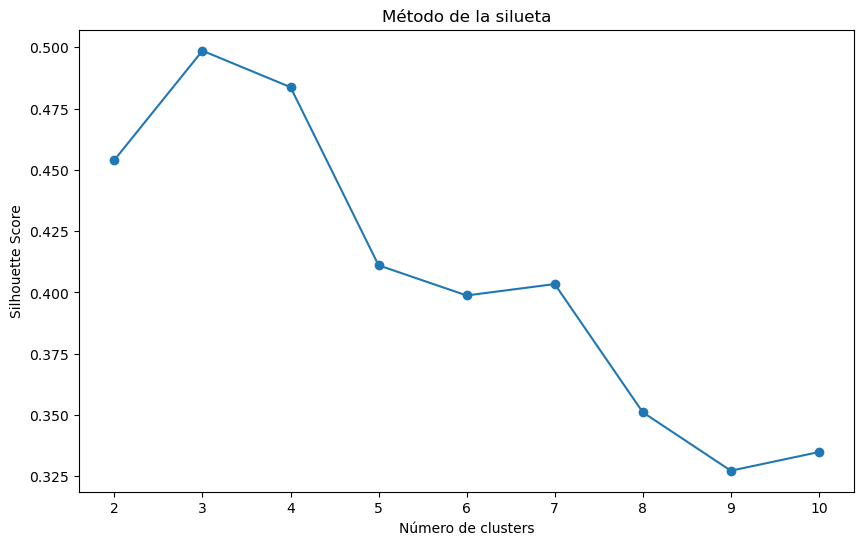

Número óptimo de clusters: 3


In [33]:
# Aplicar método de la silueta
silhouette_scores = silhouette_method(cead_comunas_1[cl_var_norm], ruta=save_cead_1)

# Seleccionar el número óptimo de clusters basado en la puntuación de la silueta
n_clusters = np.argmax(silhouette_scores) + 2  # +2 porque el rango comienza en 2

print(f"Número óptimo de clusters: {n_clusters}")

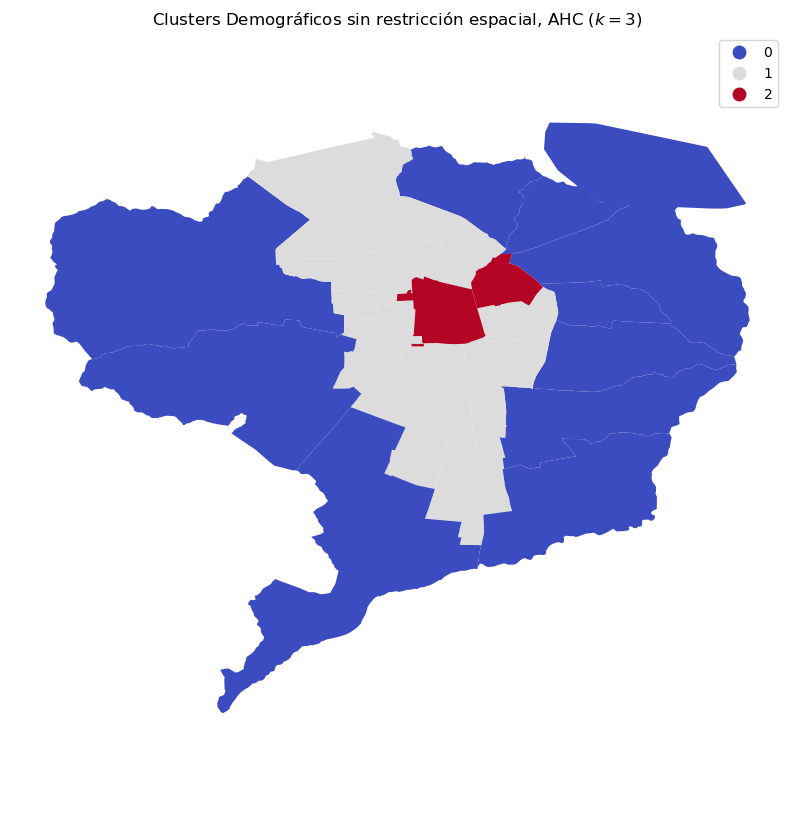

In [34]:
AHC = AgglomerativeClustering( n_clusters=n_clusters)
# Run clustering
AHC.fit(cead_comunas_1[cl_var_norm])
# Assignar etiquetas al dataframe
cead_comunas_1['ahc'] =AHC.labels_

f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_1.plot(column='ahc', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos sin restricción espacial, AHC ($k=%d$)'%n_clusters)

# Guardar la figura
guardar = os.path.join(save_cead_1, 'ahc_clusters.png')
plt.savefig(guardar)

plt.show()

In [35]:

w = weights.Queen.from_dataframe(cead_comunas_1)
w.transform ='R'
w.islands

[]

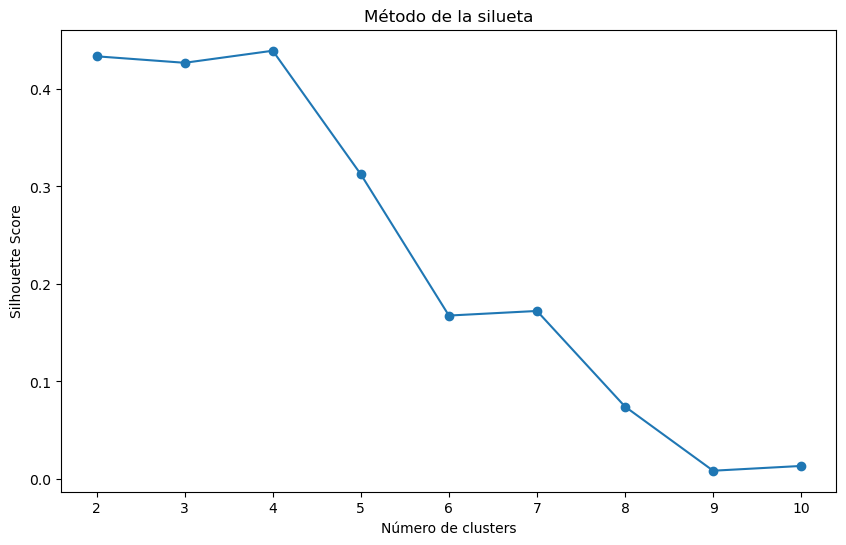

Número óptimo de clusters: 4


In [36]:
# Aplicar método de la silueta
silhouette_scores = silhouette_method(cead_comunas_1[cl_var_norm], ruta=save_cead_1,geo={'w':w, 'type': 'ahc_spatial', 'attrs_name': None})
# Seleccionar el número óptimo de clusters basado en la puntuación de la silueta
n_clusters = np.argmax(silhouette_scores) + 2  # +2 porque el rango comienza en 2

print(f"Número óptimo de clusters: {n_clusters}")

In [37]:
AHC_spatial = AgglomerativeClustering(connectivity=w.sparse,n_clusters=n_clusters)
AHC_spatial.fit(cead_comunas_1[cl_var_norm])
cead_comunas_1['ahc_spatial'] =AHC_spatial.labels_

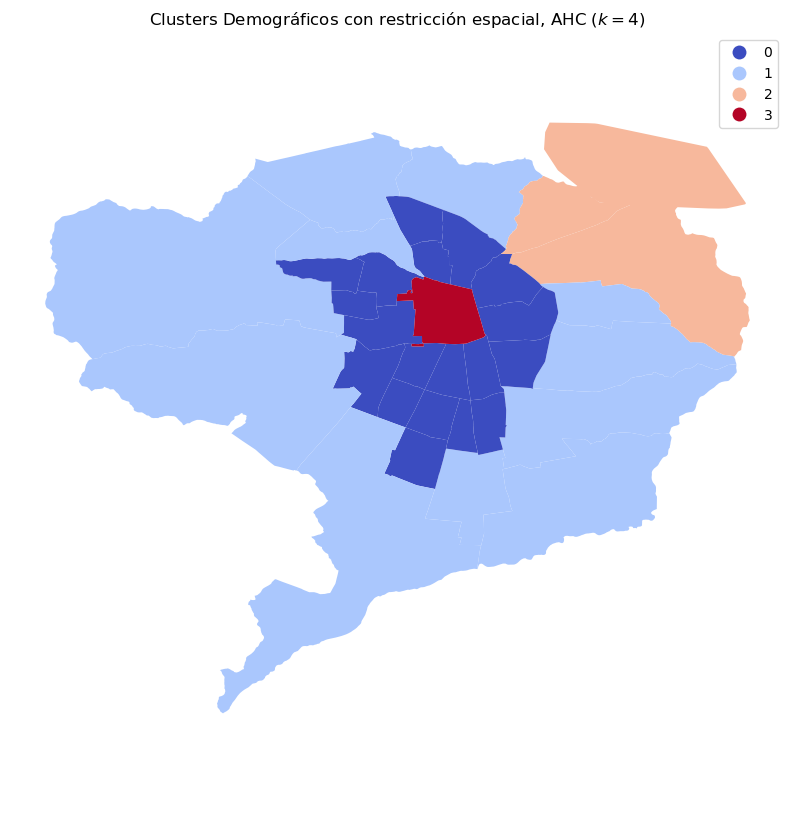

In [38]:
f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_1.plot(column='ahc_spatial', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos con restricción espacial, AHC ($k=%d$)'%n_clusters)

# Guardar la figura
guardar = os.path.join(save_cead_1, 'ahc_spatial_clusters.png')
plt.savefig(guardar)

plt.show()

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...
Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=7, score=33.59401327282862)...
Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=7, score=33.59401327282862)...


finding cut...:   0%|          | 0/31 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=7, score=33.59401327282862)...


finding cut...:   0%|          | 0/31 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=7, score=33.59401327282862)...


finding cut...:   0%|          | 0/31 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=7, score=33.59401327282862)...


finding cut...:   0%|          | 0/31 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=7, score=33.59401327282862)...


finding cut...:   0%|          | 0/31 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=7, score=33.59401327282862)...


finding cut...:   0%|          | 0/31 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=7, score=33.59401327282862)...


finding cut...:   0%|          | 0/31 [00:00<?, ?it/s]

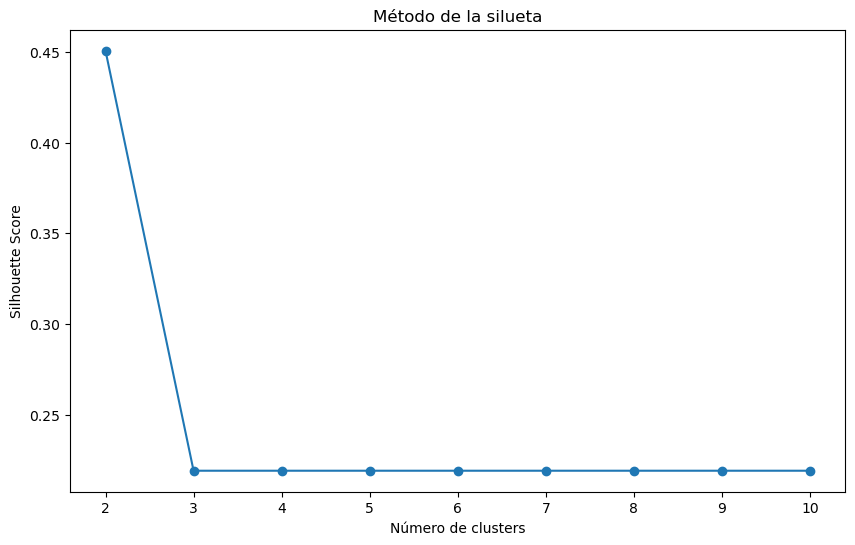

Número óptimo de clusters: 2


In [39]:

spanning_forest_kwds = dict(dissimilarity=skm.euclidean_distances,affinity=None,reduction=np.sum,center=np.mean,verbose=2)

# Aplicar método de la silueta
silhouette_scores = silhouette_method(cead_comunas_1, ruta=save_cead_1,geo={'w':w, 'type': 'skater', 'attrs_name': cl_var_norm, 'spanning_forest_kwds': spanning_forest_kwds})
# Seleccionar el número óptimo de clusters basado en la puntuación de la silueta
n_clusters = np.argmax(silhouette_scores) + 2  # +2 porque el rango comienza en 2

print(f"Número óptimo de clusters: {n_clusters}")

In [40]:

n_clusters=n_clusters
floor = 10
trace = False
islands = "increase"
attrs_name=cl_var_norm

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


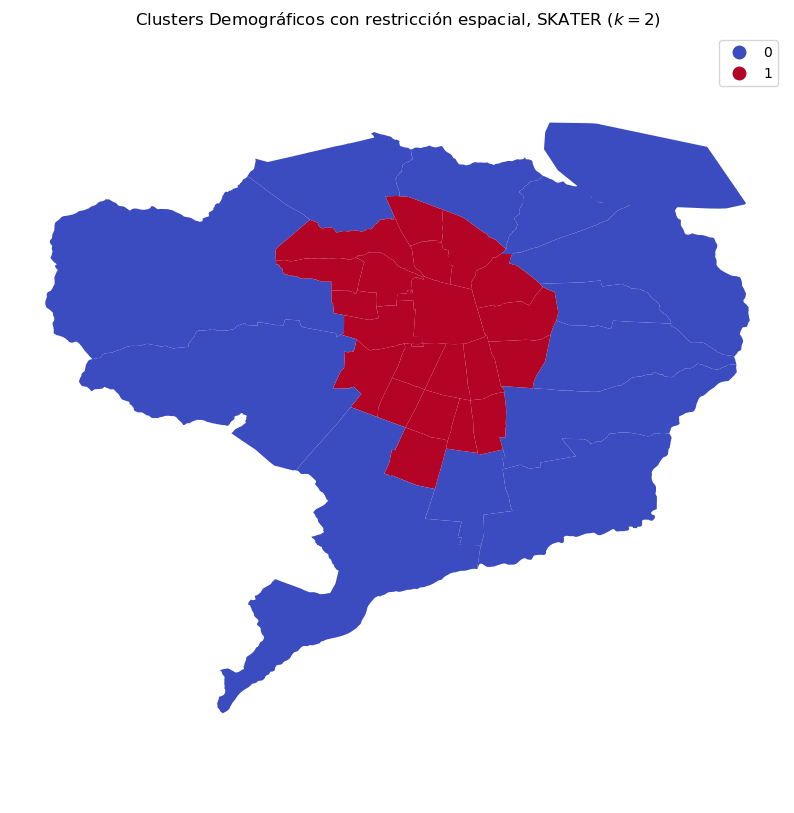

In [41]:
#Definición del modelo
model = spopt.region.Skater(cead_comunas_1,w,attrs_name,n_clusters=n_clusters,
                            floor=floor,trace=trace,islands=islands,
                            spanning_forest_kwds=spanning_forest_kwds)

#Resolver
model.solve()

#Graficar
cead_comunas_1["skater"] = model.labels_
f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_1.plot(column='skater', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos con restricción espacial, SKATER ($k=%d$)'%n_clusters)

# Guardar la figura
guardar = os.path.join(save_cead_1, 'skater.png')
plt.savefig(guardar)

plt.show()


In [42]:
#¿Cuáles son las características de cada región?
regions = cead_comunas_1.groupby('skater').mean()[attrs_name]
display(regions.T)

regions = cead_comunas_1.groupby('ahc').mean()[attrs_name]
display(regions.T)

regions = cead_comunas_1.groupby('ahc_spatial').mean()[attrs_name]
display(regions.T)

regions = cead_comunas_1.groupby('KMeans').mean()[attrs_name]
display(regions.T)

skater                   0         1
mean_cead_norm   -0.920247  0.569677
mean_endisi_norm -1.111590  0.688127
icvu_2017_norm    0.388068 -0.240233

ahc                      0         1         2
mean_cead_norm   -0.950344  0.242655  2.679012
mean_endisi_norm -1.290171  0.679690 -0.040810
icvu_2017_norm    0.567426 -0.450469  1.609087

ahc_spatial              0         1         2         3
mean_cead_norm    0.465744 -0.834267 -1.115736  3.675009
mean_endisi_norm  0.714091 -0.783574 -1.822842  0.520109
icvu_2017_norm   -0.295155 -0.146260  2.133222  0.817146

KMeans                   0         1         2         3
mean_cead_norm   -0.737647  0.339072 -1.115736  2.679012
mean_endisi_norm -0.824662  0.812302 -1.822842 -0.040810
icvu_2017_norm   -0.022443 -0.520609  2.133222  1.609087

In [43]:
# Score dataframe
df_scores = pd.DataFrame({})
df_scores['Modelo'] = ['SKATER', 'AHC', 'AHC Espacial', 'KMeans']
df_scores['CH'] = [metrics.calinski_harabasz_score(cead_comunas_1[attrs_name],cead_comunas_1['skater']),
                    metrics.calinski_harabasz_score(cead_comunas_1[attrs_name],cead_comunas_1['ahc']),
                    metrics.calinski_harabasz_score(cead_comunas_1[attrs_name],cead_comunas_1['ahc_spatial']),
                    metrics.calinski_harabasz_score(cead_comunas_1[attrs_name],cead_comunas_1['KMeans'])]
df_scores['Silhouette'] = [metrics.silhouette_score(cead_comunas_1[attrs_name],cead_comunas_1['skater']),
                            metrics.silhouette_score(cead_comunas_1[attrs_name],cead_comunas_1['ahc']),
                            metrics.silhouette_score(cead_comunas_1[attrs_name],cead_comunas_1['ahc_spatial']),
                            metrics.silhouette_score(cead_comunas_1[attrs_name],cead_comunas_1['KMeans'])]

df_scores

# EN ESTE CASO ES MEJOR EL MODELO KMeans. AHC ESPACIAL NO MEJORÓ EL RESULTADO

Modelo         CH  Silhouette
0        SKATER  27.346613    0.450841
1           AHC  29.062363    0.498635
2  AHC Espacial  23.897311    0.439144
3        KMeans  34.712009    0.487571

In [44]:
ruta_cead_2 = r"Datos\CEAD\reportes-unidadTerritorial-100mil.xlsx"
cead_2 = pd.read_excel(ruta_cead_2, thousands='.', decimal=',')
cead_2 = cead_2.round(2)

# Convertir la columna "Unidad Territorial" a mayúsculas
cead_2['UNIDAD TERRITORIAL'] = cead_2['UNIDAD TERRITORIAL'].str.upper()

# Aplicar map a la columna "UNIDAD TERRITORIAL" para eliminar los espacios en blanco al principio y al final
cead_2['UNIDAD TERRITORIAL'] = cead_2['UNIDAD TERRITORIAL'].map(str.strip)

# Filtrar solo columnas de interés
cead_2 = cead_2[['UNIDAD TERRITORIAL'] + list(range(start_year, end_year + 1))]

display(cead_2.head(5))

UNIDAD TERRITORIAL     2015     2016     2017     2018     2019  \
0             TOTAL PAÍS  4947.84  4650.13  4618.11  4507.17  4572.87   
1   REGIÓN METROPOLITANA  5267.80  4854.51  4851.29  4774.48  4834.64   
2  PROVINCIA DE SANTIAGO  5526.55  5091.94  5059.27  4933.59  4986.34   
3               SANTIAGO  9963.54  8908.84  8868.06  8289.36  8198.21   
4              CERRILLOS  6818.24  6123.25  5800.58  6216.24  6570.40   

      2020     2021     2022     2023  
0  3469.00  3386.57  4309.67  4436.24  
1  3439.45  3296.10  4118.59  4238.53  
2  3499.15  3328.64  4251.98  4426.69  
3  4883.46  4873.96  6852.38  7179.96  
4  4644.99  4228.11  5703.44  5889.41

In [45]:
# Eliminar las filas que en la columna "Unidad Territorial" no estén en la lista de comunas
cead_2 = cead_2[cead_2["UNIDAD TERRITORIAL"].isin(m_comunas)]
cead_2 = cead_2.reset_index(drop=True)
display(cead_2.head(5))

UNIDAD TERRITORIAL     2015     2016     2017     2018     2019     2020  \
0           SANTIAGO  9963.54  8908.84  8868.06  8289.36  8198.21  4883.46   
1          CERRILLOS  6818.24  6123.25  5800.58  6216.24  6570.40  4644.99   
2        CERRO NAVIA  3264.58  3295.02  3173.98  3485.45  3610.27  3110.94   
3           CONCHALÍ  3940.65  3868.82  4123.07  4413.06  4862.13  3813.36   
4          EL BOSQUE  4609.85  4075.77  4503.49  4520.79  4535.04  3289.53   

      2021     2022     2023  
0  4873.96  6852.38  7179.96  
1  4228.11  5703.44  5889.41  
2  3231.11  3863.41  4701.92  
3  3284.22  3897.92  4315.87  
4  3202.18  3580.59  3834.38

In [46]:
# Join de las cead_2 con las comunas
cead_comunas_2 = comunas.merge(cead_2, left_on='NOM_COMUNA', right_on='UNIDAD TERRITORIAL', how='inner')

# Eliminar la columna "Unidad Territorial"
cead_comunas_2 = cead_comunas_2.drop(columns=['UNIDAD TERRITORIAL'])

display(cead_comunas_2.head(5))

NOM_COMUNA                                           geometry  \
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...   
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...   
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...   
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...   
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...   

   mean_endisi_2015  mean_endisi_2016  mean_endisi_2017  mean_endisi_2018  \
0         -0.098868         -0.081216         -0.074662         -0.067701   
1          0.224280          0.242552          0.261091          0.219806   
2         -0.111830         -0.057266         -0.094771         -0.120563   
3          0.231258          0.260440          0.282941          0.249246   
4          0.072726          0.085928          0.117267          0.094583   

   mean_endisi_2019  mean_endisi_2020  mean_endisi_2021  mean_endisi_2022  \
0         -0.079220         -0.040010         -0.059132         -0.058857   
1          0.198873          0.208580          0.193865          0.206738   
2         -0.144225         -0.124776         -0.167283         -0.126357   
3          0.218385          0.218902          0.196848          0.194019   
4          0.058612          0.054557          0.000846          0.037702   

   mean_endisi_2023     2015     2016     2017     2018     2019     2020  \
0         -0.014481  4415.44  3952.98  3956.71  4470.28  4698.67  3482.67   
1          0.258278  3264.58  3295.02  3173.98  3485.45  3610.27  3110.94   
2         -0.094749  6288.55  5425.30  5189.40  4869.45  4937.52  3352.94   
3          0.237533  3940.65  3868.82  4123.07  4413.06  4862.13  3813.36   
4          0.094690  4677.58  4359.64  4226.74  4364.29  4560.58  3495.39   

      2021     2022     2023  
0  3458.21  4144.89  4612.71  
1  3231.11  3863.41  4701.92  
2  3238.01  3772.72  4013.80  
3  3284.22  3897.92  4315.87  
4  3227.17  3840.57  3964.03

In [47]:
# Promedio de criminalidad de los años 2015 a 2023
cead_comunas_2['mean_cead'] = cead_comunas_2[[year for year in range(start_year, end_year + 1)]].mean(axis=1)

# Promedio endisi de los años 2015 a 2023
cead_comunas_2['mean_endisi'] = cead_comunas_2[[f'mean_endisi_{year}' for year in range(start_year, end_year + 1)]].mean(axis=1)

# Seleccionar columnas de interés
cead_comunas_2 = cead_comunas_2[['NOM_COMUNA', 'mean_cead', 'mean_endisi', 'geometry']]
display(cead_comunas_2.head(5))

NOM_COMUNA    mean_cead  mean_endisi  \
0     PUDAHUEL  4132.506667    -0.063794   
1  CERRO NAVIA  3526.297778     0.223785   
2   HUECHURABA  4565.298889    -0.115758   
3     CONCHALÍ  4057.677778     0.232175   
4   LA PINTANA  4079.554444     0.068546   

                                            geometry  
0  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...  
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...  
2  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...  
3  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...  
4  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...

In [48]:
# Join de las comunas con el ICVU
cead_comunas_2 = cead_comunas_2.merge(gdf_icvu, on='NOM_COMUNA', how='inner')
display(cead_comunas_2.head(5))

NOM_COMUNA    mean_cead  mean_endisi  \
0     PUDAHUEL  4132.506667    -0.063794   
1  CERRO NAVIA  3526.297778     0.223785   
2   HUECHURABA  4565.298889    -0.115758   
3     CONCHALÍ  4057.677778     0.232175   
4   LA PINTANA  4079.554444     0.068546   

                                            geometry  icvu_2017  
0  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...       36.2  
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...       26.9  
2  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...       37.2  
3  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...       30.7  
4  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...       24.2

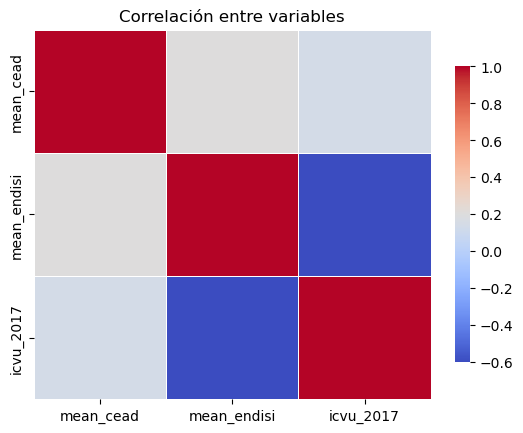

In [49]:
corr = cead_comunas_2.corr()
sns.heatmap(corr, square=False, linewidths=.5, cbar_kws={"shrink": .8},cmap='coolwarm');
plt.title('Correlación entre variables')

# Guardar la figura
guardar = os.path.join(save_cead_2, 'correlacion.png')
plt.savefig(guardar)

plt.show()


In [50]:
cead_comunas_2[cl_var_norm] = scaler.fit_transform(cead_comunas_2[cl_var])

cead_comunas_2.head(5)

NOM_COMUNA    mean_cead  mean_endisi  \
0     PUDAHUEL  4132.506667    -0.063794   
1  CERRO NAVIA  3526.297778     0.223785   
2   HUECHURABA  4565.298889    -0.115758   
3     CONCHALÍ  4057.677778     0.232175   
4   LA PINTANA  4079.554444     0.068546   

                                            geometry  icvu_2017  \
0  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...       36.2   
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...       26.9   
2  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...       37.2   
3  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...       30.7   
4  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...       24.2   

   mean_cead_norm  mean_endisi_norm  icvu_2017_norm  
0       -0.350454         -1.130948       -0.269381  
1       -0.852192          0.779308       -0.980981  
2        0.007754         -1.476118       -0.192865  
3       -0.412387          0.835039       -0.690220  
4       -0.394280         -0.251876       -1.187574

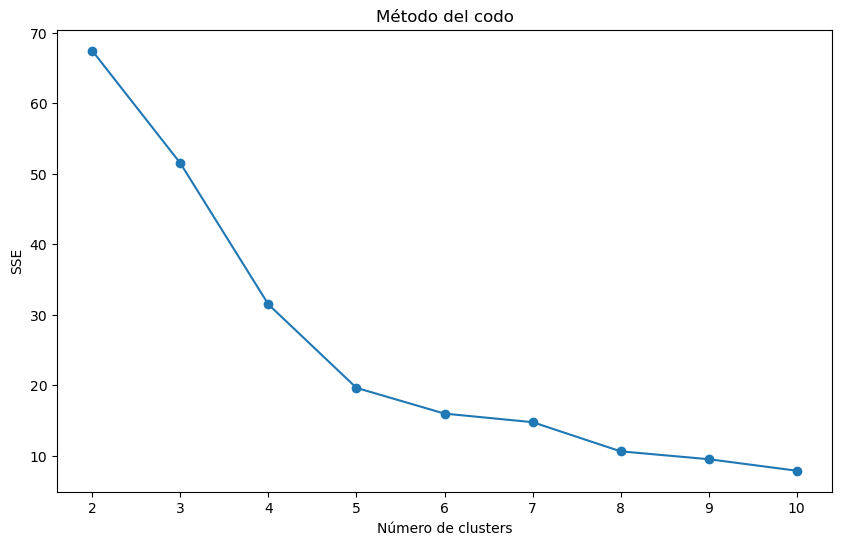

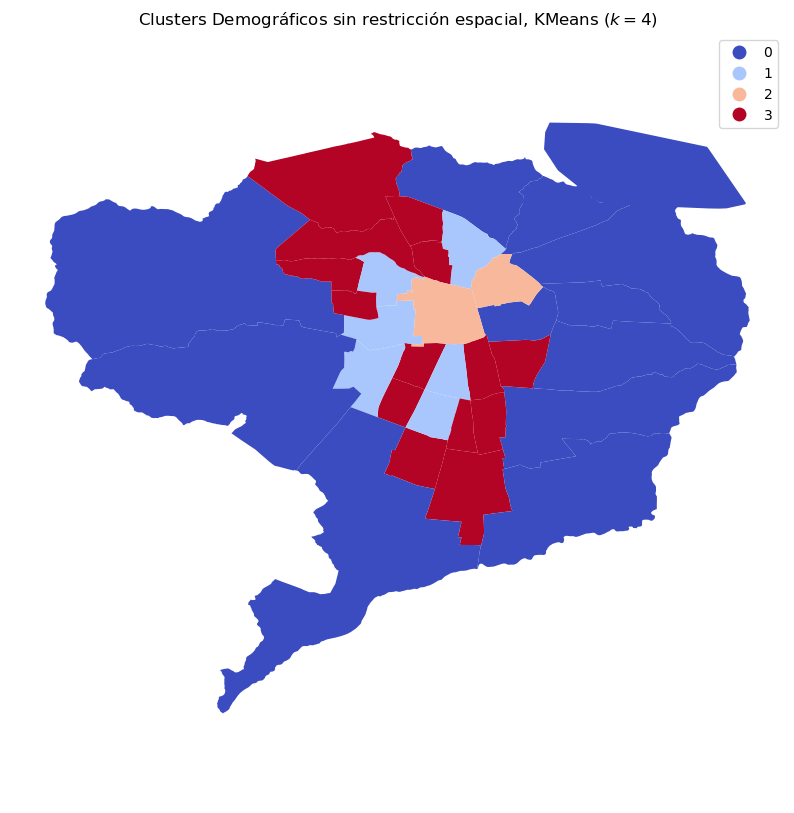

In [51]:
# Aplicar método del codo
elbow_method(cead_comunas_2[cl_var_norm], max_clusters=10, ruta=save_cead_2)

# Al ver el gráfico, se puede observar que el codo se encuentra en k=3, por lo que se utilizarán 4 clusters
n_clusters = 4

# Realizar KMeans
kmeans = KMeans(n_clusters=n_clusters)
cead_comunas_2['KMeans'] = kmeans.fit_predict(cead_comunas_2[cl_var_norm])

# Visualizar los clusters
f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_2.plot(column='KMeans', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos sin restricción espacial, KMeans ($k=%d$)'%n_clusters)

# Guardar la figura
guardar = os.path.join(save_cead_2, 'kmeans_clusters.png')
plt.savefig(guardar)

plt.show()

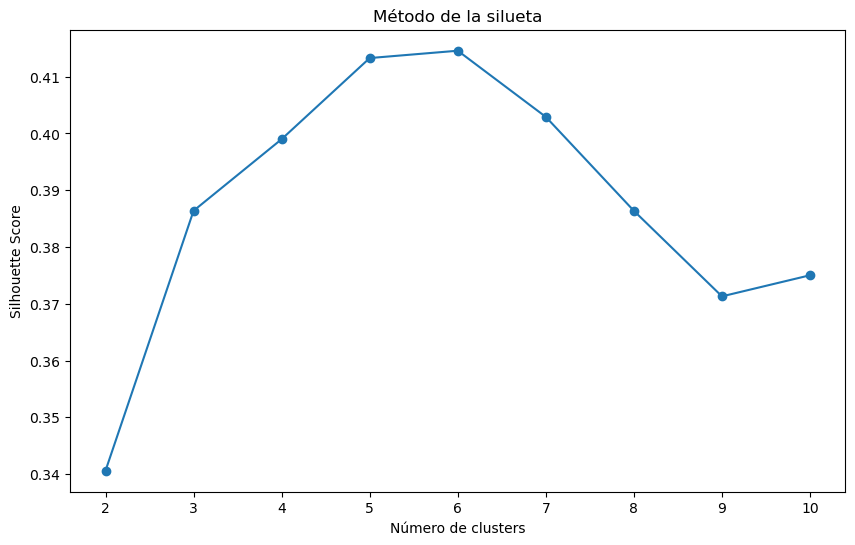

Número óptimo de clusters: 6


In [52]:
# Aplicar método de la silueta
silhouette_scores = silhouette_method(cead_comunas_2[cl_var_norm], ruta=save_cead_2)

# Seleccionar el número óptimo de clusters basado en la puntuación de la silueta
n_clusters = np.argmax(silhouette_scores) + 2  # +2 porque el rango comienza en 2

print(f"Número óptimo de clusters: {n_clusters}")

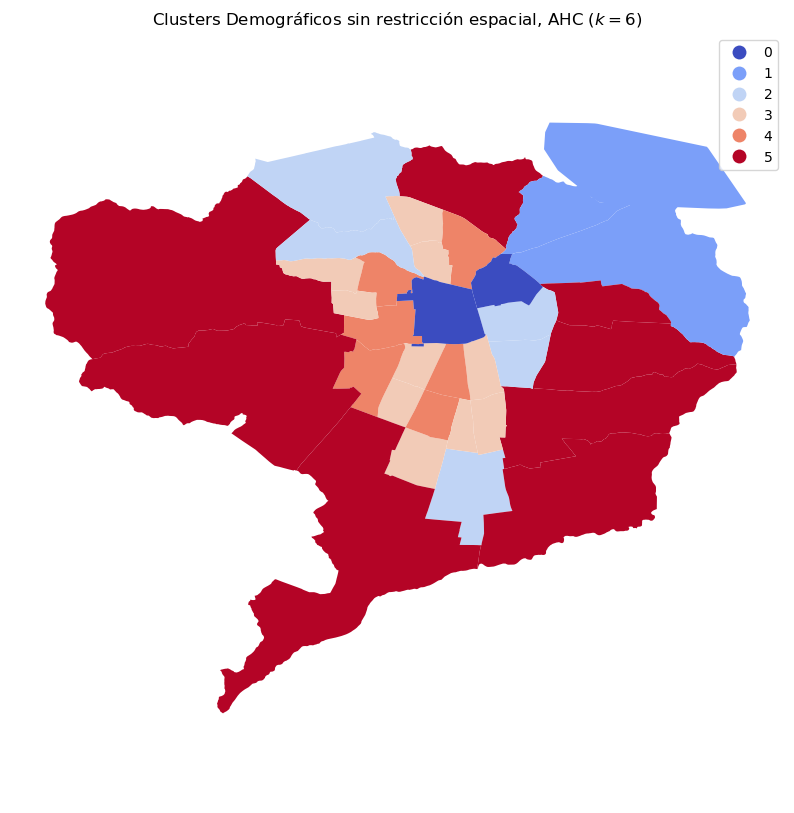

In [53]:
AHC = AgglomerativeClustering( n_clusters=n_clusters)
# Run clustering
AHC.fit(cead_comunas_2[cl_var_norm])
# Assignar etiquetas al dataframe
cead_comunas_2['ahc'] =AHC.labels_

f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_2.plot(column='ahc', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos sin restricción espacial, AHC ($k=%d$)'%n_clusters)

# Guardar la figura
guardar = os.path.join(save_cead_2, 'ahc_clusters.png')
plt.savefig(guardar)

plt.show()

In [54]:

w = weights.Queen.from_dataframe(cead_comunas_2)
w.transform ='R'
w.islands

[]

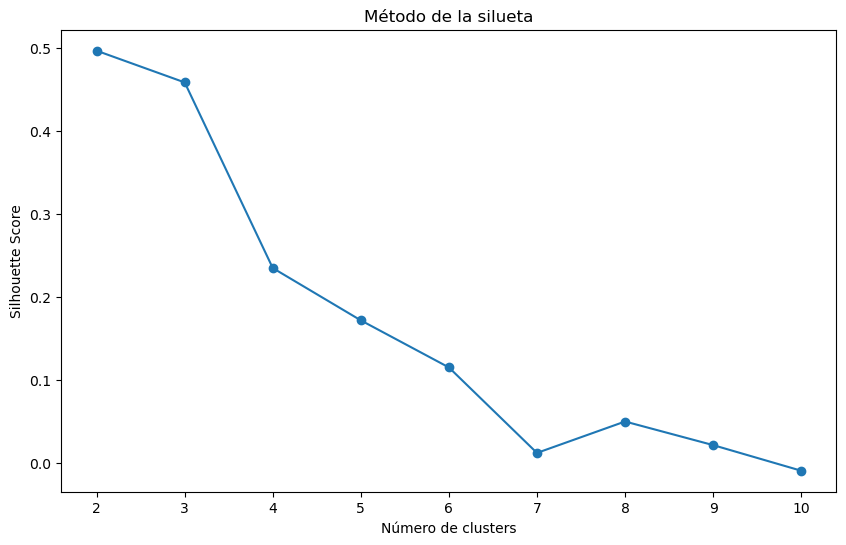

Número óptimo de clusters: 2


In [55]:
# Aplicar método de la silueta
silhouette_scores = silhouette_method(cead_comunas_2[cl_var_norm], ruta=save_cead_2,geo={'w':w, 'type': 'ahc_spatial', 'attrs_name': None})
# Seleccionar el número óptimo de clusters basado en la puntuación de la silueta
n_clusters = np.argmax(silhouette_scores) + 2  # +2 porque el rango comienza en 2

print(f"Número óptimo de clusters: {n_clusters}")

In [56]:
AHC_spatial = AgglomerativeClustering(connectivity=w.sparse,n_clusters=n_clusters)
AHC_spatial.fit(cead_comunas_2[cl_var_norm])
cead_comunas_2['ahc_spatial'] =AHC_spatial.labels_

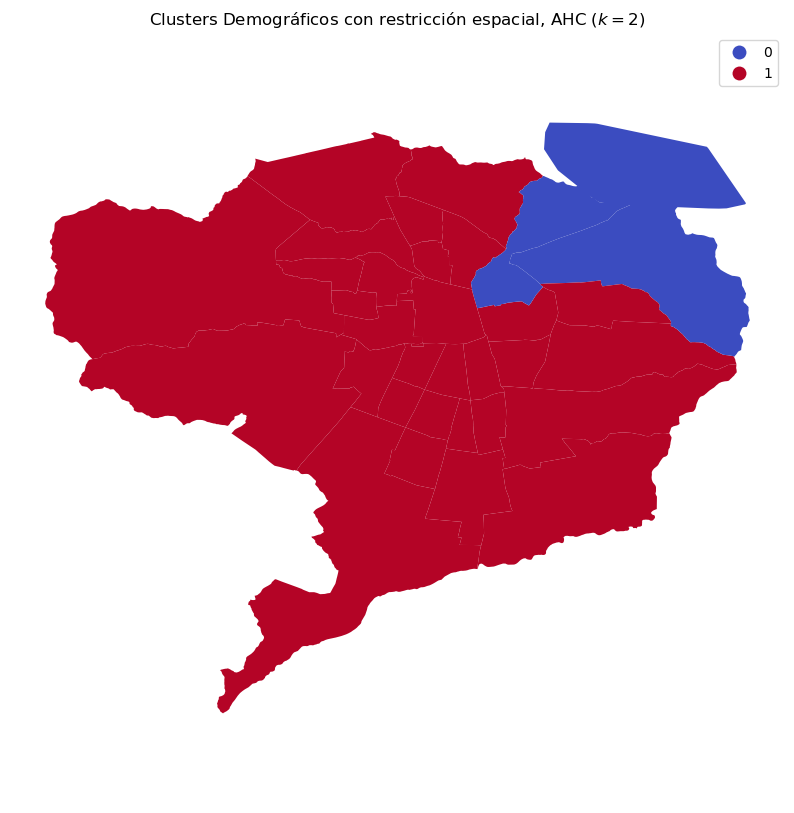

In [57]:
f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_2.plot(column='ahc_spatial', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos con restricción espacial, AHC ($k=%d$)'%n_clusters)

# Guardar la figura
guardar = os.path.join(save_cead_2, 'ahc_spatial_clusters.png')
plt.savefig(guardar)

plt.show()

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...
Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

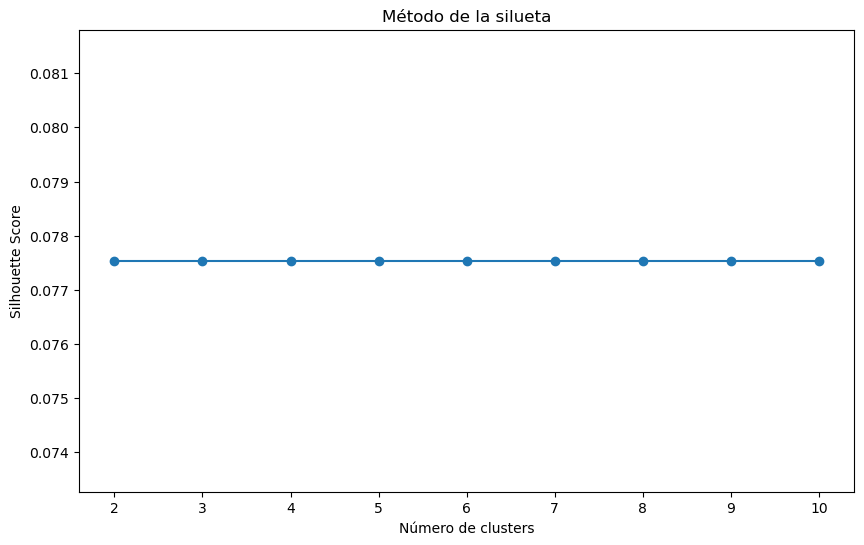

Número óptimo de clusters: 2


In [58]:

spanning_forest_kwds = dict(dissimilarity=skm.euclidean_distances,affinity=None,reduction=np.sum,center=np.mean,verbose=2)

# Aplicar método de la silueta
silhouette_scores = silhouette_method(cead_comunas_2, geo={'w':w, 'type': 'skater', 'attrs_name': cl_var_norm, 'spanning_forest_kwds': spanning_forest_kwds}, ruta=save_cead_2)
# Seleccionar el número óptimo de clusters basado en la puntuación de la silueta
n_clusters = np.argmax(silhouette_scores) + 2  # +2 porque el rango comienza en 2

print(f"Número óptimo de clusters: {n_clusters}")

In [59]:
n_clusters=n_clusters
floor = 10
trace = False
islands = "increase"
attrs_name=cl_var_norm

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=29, score=49.22280432121562)...


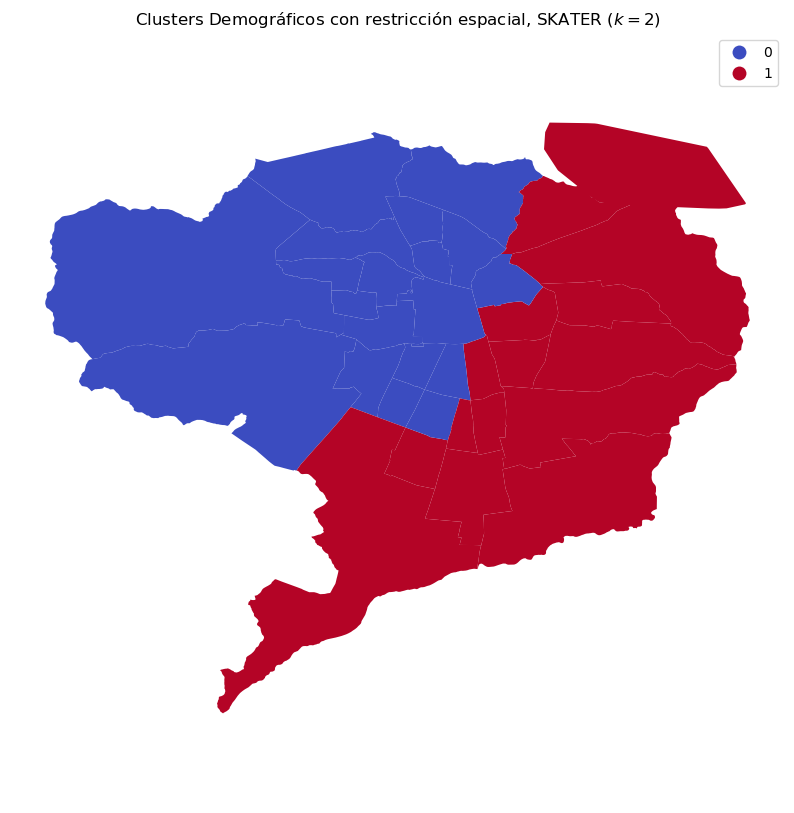

In [60]:
#Definición del modelo
model = spopt.region.Skater(cead_comunas_2,w,attrs_name,n_clusters=n_clusters,
                            floor=floor,trace=trace,islands=islands,
                            spanning_forest_kwds=spanning_forest_kwds)

#Resolver
model.solve()

#Graficar
cead_comunas_2["skater"] = model.labels_
f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_2.plot(column='skater', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos con restricción espacial, SKATER ($k=%d$)'%n_clusters)

# Guardar la figura
guardar = os.path.join(save_cead_2, 'skater.png')
plt.savefig(guardar)

plt.show()


In [61]:
regions = cead_comunas_2.groupby('skater').mean()[attrs_name]
display(regions.T)

regions = cead_comunas_2.groupby('ahc').mean()[attrs_name]
display(regions.T)

regions = cead_comunas_2.groupby('ahc_spatial').mean()[attrs_name]
display(regions.T)

regions = cead_comunas_2.groupby('KMeans').mean()[attrs_name]
display(regions.T)

skater                   0         1
mean_cead_norm    0.330929 -0.419176
mean_endisi_norm  0.325623 -0.412456
icvu_2017_norm   -0.260522  0.329994

ahc                      0         1         2         3         4         5
mean_cead_norm    3.031027 -1.011718 -0.496512 -0.364819  0.932192 -0.311162
mean_endisi_norm -0.040810 -1.822842  0.112851  1.000517  0.617345 -1.090419
icvu_2017_norm    1.609087  2.133222  0.055047 -0.715470 -0.430065 -0.019748

ahc_spatial              0         1
mean_cead_norm    0.135645 -0.018086
mean_endisi_norm -1.517563  0.202342
icvu_2017_norm    2.200174 -0.293357

KMeans                   0         1         2         3
mean_cead_norm   -0.488155  0.932192  3.031027 -0.414096
mean_endisi_norm -1.190085  0.617345 -0.040810  0.761326
icvu_2017_norm    0.612466 -0.430065  1.609087 -0.570527

In [62]:
# Score dataframe
df_scores = pd.DataFrame({})
df_scores['Modelo'] = ['SKATER', 'AHC', 'AHC Espacial', 'KMeans']
df_scores['CH'] = [metrics.calinski_harabasz_score(cead_comunas_2[attrs_name],cead_comunas_2['skater']),
                    metrics.calinski_harabasz_score(cead_comunas_2[attrs_name],cead_comunas_2['ahc']),
                    metrics.calinski_harabasz_score(cead_comunas_2[attrs_name],cead_comunas_2['ahc_spatial']),
                    metrics.calinski_harabasz_score(cead_comunas_2[attrs_name],cead_comunas_2['KMeans'])]
df_scores['Silhouette'] = [metrics.silhouette_score(cead_comunas_2[attrs_name],cead_comunas_2['skater']),
                            metrics.silhouette_score(cead_comunas_2[attrs_name],cead_comunas_2['ahc']),
                            metrics.silhouette_score(cead_comunas_2[attrs_name],cead_comunas_2['ahc_spatial']),
                            metrics.silhouette_score(cead_comunas_2[attrs_name],cead_comunas_2['KMeans'])]

display(df_scores)


Modelo         CH  Silhouette
0        SKATER   4.349780    0.077538
1           AHC  32.274517    0.414572
2  AHC Espacial  14.942732    0.496438
3        KMeans  23.547207    0.382095